In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import trapezoid as trapz
from mpmath import mp, invertlaplace, mpc, mpf, sqrt, pi, exp, erfc
import scipy
import math

x_0_sampled = False

_k_b = scipy.constants.k
_rho = 4200
_rho_f = 789

# _r =  2.6392235755368e-06
# _K = 8.061743253740993e-05
# _gain = np.sqrt(335982165125421.5 )

_r =  1.673973370516074e-06
_K = 7.264521400417836e-05
_gain = np.sqrt(630330834489321.9)

_m = 4/3 *np.pi *_r**3*_rho + 2/3 *np.pi *_r**3*_rho_f
_temp = 293
_viscous = 0.36e-3
_v_force = 6*np.pi*_r*_viscous


def a_inverse_form(t, roots):
    return np.real((1/_m) * sum(
        (z**3 * scipy.special.erfcx(z * np.sqrt(t))) /
        (np.prod([z - z_j for z_j in roots if z != z_j])) for z in roots))

def b_inverse_form(t, roots):
    return np.real((1/_m) * sum(
        (z * scipy.special.erfcx(z * np.sqrt(t))) /
        (np.prod([z - z_j for z_j in roots if z != z_j])) for z in roots))

def c_inverse_form(t, roots):
    a = roots[0]
    b = roots[1]
    c = roots[2]
    d = roots[3]

    m_over_k = 1/(a*b*c*d)

    ret = np.real((1/_m) * sum(
        (scipy.special.erfcx(z * np.sqrt(t))) /
        (z*(np.prod([z - z_j for z_j in roots if z != z_j]))) for z in roots))

    return ret + m_over_k/_m

def s_half_b_inverse_form(t, roots):
    return np.real((-1/_m) * sum(
        (z**2 * scipy.special.erfcx(z * np.sqrt(t))) /
        (np.prod([z - z_j for z_j in roots if z != z_j])) for z in roots))

def ensemble_r_term(t1, t2, m, K, roots):
    return np.real((_k_b*_temp)*(c_inverse_form(t1, roots) + c_inverse_form(t2, roots) - c_inverse_form(np.abs(t2-t1), roots) - m*b_inverse_form(t1, roots)*b_inverse_form(t2, roots) - K*c_inverse_form(t1, roots)*c_inverse_form(t2, roots)))

def e_and_f(t, mass, radius, rho_f, eta, x0, v0, roots):
    gamma = 6*np.pi*radius*eta
    z = 6*radius**2*np.pi*np.sqrt(rho_f*eta)
    return mass*x0*a_inverse_form(t, roots) + mass*v0*b_inverse_form(t, roots) + gamma*x0*b_inverse_form(t, roots) + z*x0*s_half_b_inverse_form(t, roots) #+ z*v0*s_minus_half_b_inverse_form(t, roots)

def x_t1_x_t2(t1, t2, m, K, radius, eta, rho_f, x0, v0):
    return e_and_f(t1, m, radius, rho_f, eta, x0, v0, roots)*e_and_f(t2, m, radius, rho_f, eta, x0, v0, roots) + ensemble_r_term(t1,t2, m, K, roots)

def full_hydro_msd(t1, t2, m, K, radius, eta, rho_f, x0, v0):
    return x_t1_x_t2(t1, t1, m, K, radius, eta, rho_f, x0, v0) + x_t1_x_t2(t2, t2, m, K, radius, eta, rho_f, x0, v0) - 2 * x_t1_x_t2(t1, t2, m, K, radius, eta, rho_f, x0, v0)

def v_t1_v_t2(t1, t2, m, K):
    return _k_b*_temp*(a_inverse_form(np.abs(t2-t1), roots) - m*a_inverse_form(t1, roots)*a_inverse_form(t2, roots) - K*b_inverse_form(t1, roots)*b_inverse_form(t2, roots))


times_analytic = np.logspace(-6.5, -1.5, 1000)


def compute_roots(m, K, r, eta, rho_f):
    t_f = (rho_f * r ** 2) / eta
    t_p = m / (6 * np.pi * r * eta)
    a = 1
    b = -6*math.pi*r**2*np.sqrt(rho_f*eta)/m
    c = 6*math.pi*r*eta/m
    d = 0
    e = K/m

    coeffs = [a, b, c, d, e]
    return np.roots(coeffs)

roots = compute_roots(_m, _K, _r, _viscous, _rho_f)

mu = 0
# sigma_v = np.sqrt(_k_b*_temp/_m)
sigma_x = np.sqrt(_k_b*_temp/_K)
num_samples = 5000

# initial_conditions_v = np.random.normal(mu, sigma_v, num_samples)
initial_conditions_x = np.random.normal(mu, sigma_x, num_samples)

results_speed = np.zeros((num_samples, len(times_analytic)))
results_speed_no_half = np.zeros((num_samples, len(times_analytic)))
results = np.zeros((num_samples, len(times_analytic)))

speeds_analytic_no_half = []

if x_0_sampled:
    for i in range(num_samples):
        results_speed_no_half[i, :] = full_hydro_msd(0, times_analytic, _m, _K, _r, _viscous, _rho_f, initial_conditions_x[i], 0* np.sqrt(_k_b*_temp/_m))
    speeds_analytic_no_half.append(results_speed_no_half.mean(axis=0))
else:
    speeds_analytic_no_half.append(full_hydro_msd(0, times_analytic, _m, _K, _r, _viscous, _rho_f, 0, 0))

# High precision for inverse Laplace
mp.dps = 30

# History term in Laplace domain - see overlead doc
def F(s, tau):
    s = mpc(s)
    tau = mpf(tau)
    D = _m*(roots[0] + sqrt(s)) * (roots[1] + sqrt(s)) * (roots[2] + sqrt(s)) * (roots[3] + sqrt(s))
    inv = 1/sqrt(-tau) - 1 * exp(-tau*s) * sqrt(s) * sqrt(pi) * erfc(sqrt(-tau*s))
    return inv / D

# Inverse Laplace transform F^-1[f(s, tau)] -> f(t, tau)
def f(t, tau):
    def F_fixed_s(s):
        return F(s, tau) # Calls the actual function
    return float(mp.re(invertlaplace(F_fixed_s, t, method='talbot')))

# Time grid (log-spaced in negative time)
tau_min = 1e-12
tau_max = 1e-1
N = 100
tau_array = -np.logspace(np.log10(tau_min), np.log10(tau_max), N)[::-1] # Backwards logspace
z = 6*_r**2*np.sqrt(np.pi*_viscous*_rho_f)

# Fixed t value at which to evaluate MSD_history(t) importance
points = 30
t_evals = np.logspace(-6.5, -1.5, points)
msd_hs = []
count = 0

for t_eval in t_evals:
    count +=1
    print(f"{count}/{points}")
    # Compute f(t, tau) for all tau
    f_vals = np.array([f(t_eval, tau) for tau in tau_array]) # tau is backwards time, t_eval is forwards

    # Build the 2D integrand: VACF(tau1, tau2) * f(t, tau1) * f(t, tau2)
    T1, T2 = np.meshgrid(tau_array, tau_array, indexing='ij')
    f1 = f_vals[:, np.newaxis]
    f2 = f_vals[np.newaxis, :]
    VACF_grid = v_t1_v_t2(-1*T1, -1*T2, _m, _K) # This function is the VACF from the Clerx and Schram paper (before they take the stationary part) so it inherently assumes no history ... It does give us the aprroximate strength of the VACF given the lag time between T1 and T2...
    integrand = VACF_grid * f1 * f2 # Here we construct the full integrand in matrix form. It corresponds to the second term in equation 36 from the history write up... The third/fourth term are due to random force/velocity correlation...

    # Integrate over tau1 and tau2
    msd_history = trapz(trapz(integrand, tau_array, axis=1), tau_array)
    # print(f"MSD_history(t = {t_eval:.2e}) = {msd_history:.5e}")
    msd_hs.append(msd_history*z**2)


1/30
2/30
3/30
4/30
5/30
6/30
7/30
8/30
9/30
10/30
11/30
12/30
13/30
14/30
15/30
16/30
17/30
18/30
19/30
20/30
21/30
22/30
23/30
24/30
25/30
26/30
27/30
28/30
29/30
30/30


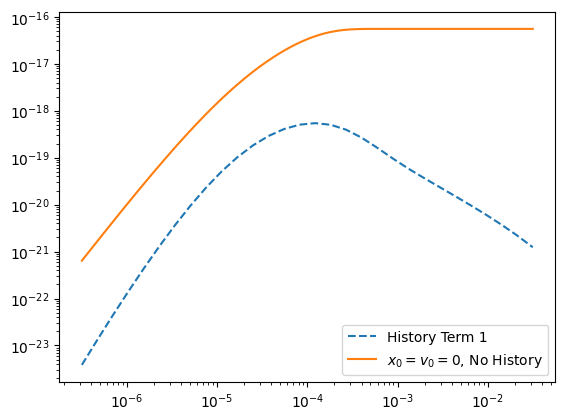

In [5]:
plt.plot(t_evals, msd_hs, linestyle='dashed', label="History Term 1")
plt.plot(times_analytic, speeds_analytic_no_half[0], label = r"$x_0 = v_0 = 0$, No History")
plt.plot()
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()

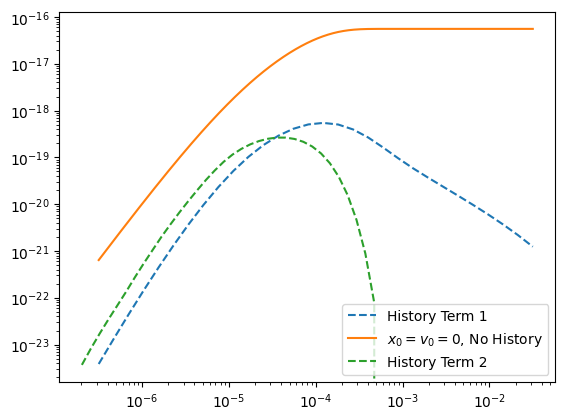

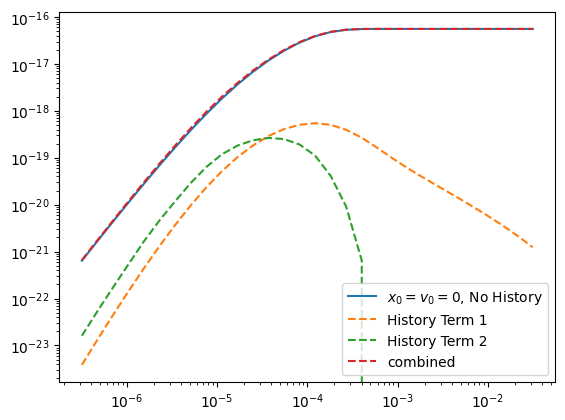

In [22]:
import numpy as np

# Load the data, skipping the header
data = np.loadtxt(r"C:\Users\Cole Thumann\Downloads\r_v_cross_correlation.txt", skiprows=1)

# Split into two arrays
plot_times_loaded = data[:, 0]
results_loaded = data[:, 1]

mask = (plot_times_loaded > 2e-7)

# Apply the same mask to both arrays
plot_times_loaded_cut = plot_times_loaded[mask]
results_loaded_cut = results_loaded[mask]

plt.plot(t_evals, msd_hs, linestyle='dashed', label="History Term 1")
plt.plot(times_analytic, speeds_analytic_no_half[0], label = r"$x_0 = v_0 = 0$, No History")
plt.plot(plot_times_loaded_cut, results_loaded_cut, linestyle='dashed', label = r"History Term 2")
plt.plot()
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()


from scipy.interpolate import interp1d

interpo = interp1d(times_analytic, speeds_analytic_no_half[0], fill_value='extrapolate')
interpo2 = interp1d(plot_times_loaded_cut, results_loaded_cut, fill_value='extrapolate')
plot_v0 = interpo(t_evals)
plot_vr = interpo2(t_evals)

plt.plot(t_evals, plot_v0, label = r"$x_0 = v_0 = 0$, No History")
plt.plot(t_evals, msd_hs, linestyle='dashed', label="History Term 1")
plt.plot(t_evals[:20], plot_vr[:20], linestyle='dashed', label = r"History Term 2")
plt.plot(t_evals, msd_hs+plot_v0+plot_vr, linestyle='dashed', label = r"combined")
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()


get a s


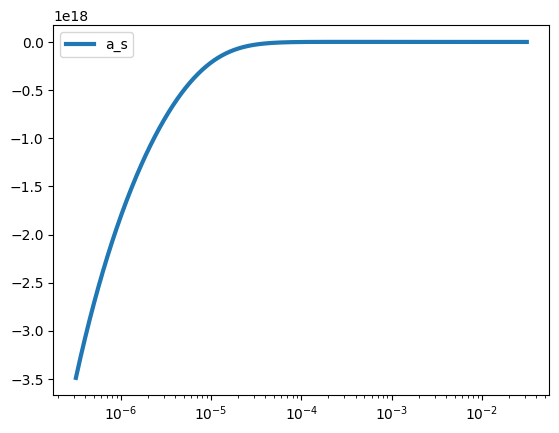

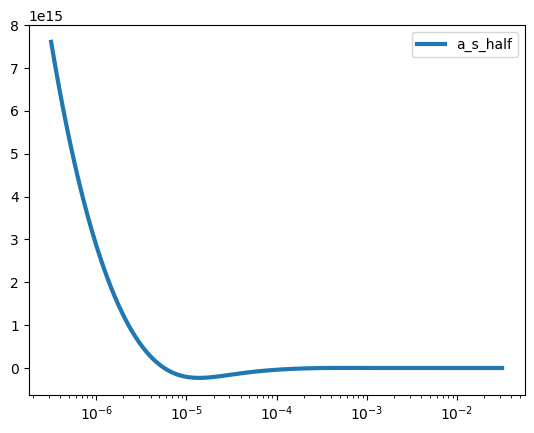

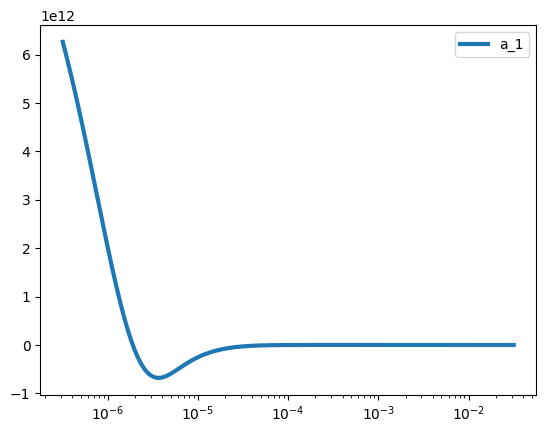

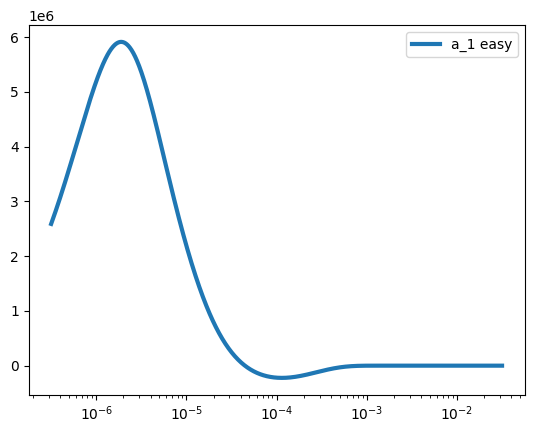

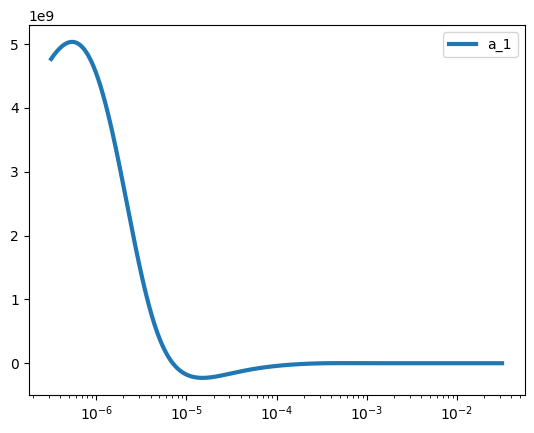

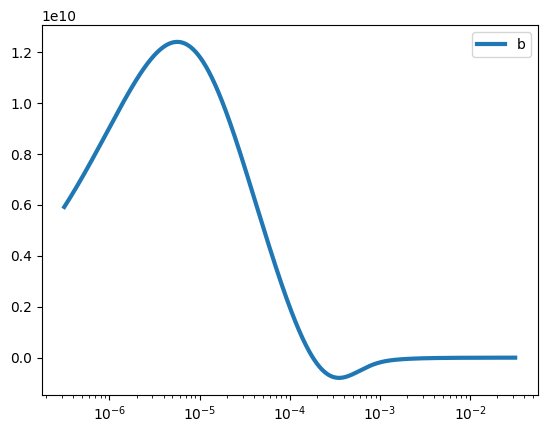

[ 0  1  2  5 11 10  9  8  4  3  7  6]
[ 0  1  2  5 11 10  9  8  4  3  7  6]
[ 0  1  2  5 11 10  9  8  4  3  7  6]
[ 0  1  2  5 11 10  9  8  4  3  7  6]
[ 0  1  2  5 11 10  9  8  4  3  7  6]
[ 0  1  2  5 11 10  9  8  4  3  7  6]
[ 0  1  2  5 11 10  9  8  4  3  7  6]
[ 0  1  2  5 11 10  9  8  4  3  7  6]
[ 0  1  2  5 11 10  9  8  4  3  7  6]
[ 0  1  2  5 11 10  9  8  4  3  7  6]
[ 0  1  2  5 11 10  9  8  4  3  7  6]
[ 0  1  2  5 11 10  9  8  4  3  7  6]
[ 0  1  2  5 11 10  9  8  4  3  7  6]
[ 0  1  2  5 11 10  9  8  4  3  7  6]
[ 0  1  2  5 11 10  9  8  4  3  7  6]
[ 0  1  2  5 11 10  9  8  4  3  7  6]
[ 0  1  2  5 11 10  9  8  4  3  7  6]
[ 0  1  2  5 11 10  9  8  4  3  7  6]
[ 0  1  2  5 11 10  9  8  7  4  3  6]
[ 0  1  2  5 11 10  9  8  7  4  3  6]
[ 0  1  2  5 11 10  9  8  7  4  3  6]
[ 0  1  7  2  5 10  9  8 11  4  3  6]
[ 0  1  7  2  5 10  9  8 11  4  3  6]
[ 0  1  7  2  5 10  9  8 11  4  3  6]
[ 3  4  7  0  1  2  5  8 10  9 11  6]
[ 3  4  7  2  5 10  9  8 11  1  0  6]
[ 3  4  7  2

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from mpmath import mp, invertlaplace

# THIS IS WHERE WE ESTIMATE <R(t1)v(t2)>

# THIS IS FOR THE 2nd TERM
# Set desired precision
mp.dps = 15  # or however many digits of precision you want

# Your Laplace-domain function
def a_s(s):
    D = _m * (roots[0] + mp.sqrt(s)) * (roots[1] + mp.sqrt(s)) * \
        (roots[2] + mp.sqrt(s)) * (roots[3] + mp.sqrt(s))
    num = s**2
    return num / D

# Scalar inverse Laplace
def get_a_s_scalar(t):
    return float(mp.re(invertlaplace(a_s, t, method='talbot')))

# Vectorized version for arrays
get_a_s = np.vectorize(get_a_s_scalar)

print("get a s")

plt.plot(times_analytic, get_a_s(times_analytic), linewidth=3, label="a_s")
plt.xscale('log')
plt.legend()
# plt.yscale('log')
plt.show()

# THIS IS FOR THE 8th TERM
def a_s_half(s):
    D = _m * (roots[0] + mp.sqrt(s)) * (roots[1] + mp.sqrt(s)) * \
        (roots[2] + mp.sqrt(s)) * (roots[3] + mp.sqrt(s))
    num = s**(3/2)
    return num / D

# Scalar inverse Laplace
def get_a_s_half_scalar(t):
    return float(mp.re(invertlaplace(a_s_half, t, method='talbot')))

# Vectorized version for arrays
get_a_s_half = np.vectorize(get_a_s_half_scalar)

plt.plot(times_analytic, get_a_s_half(times_analytic), linewidth=3, label="a_s_half")
plt.xscale('log')
# plt.yscale('log')
plt.legend()
plt.show()
# THIS IS FOR THE FIRST TERM

# Your Laplace-domain function
def a_1(s, a):
    D = _m * (roots[0] + mp.sqrt(s)) * (roots[1] + mp.sqrt(s)) * \
        (roots[2] + mp.sqrt(s)) * (roots[3] + mp.sqrt(s))
    num = s**2/(s+a)
    return num / D

# Scalar inverse Laplace
def get_a_s1(t, a):
    def a_1_call(s):
        return a_1(s,a)
    return float(mp.re(invertlaplace(a_1_call, t, method='talbot')))

# Vectorized version for arrays
get_a_1 = np.vectorize(get_a_s1)
s_prime = 1e6

# Term 1 easier part

# Your Laplace-domain function
def a_1_prime(s, a):
    D = _m * (roots[0] + mp.sqrt(s)) * (roots[1] + mp.sqrt(s)) * \
        (roots[2] + mp.sqrt(s)) * (roots[3] + mp.sqrt(s))
    num = s/(s+a)
    return num / D

# Scalar inverse Laplace
def get_a_1_prime(t, a):
    def a_1_prime_call(s):
        return a_1_prime(s,a)
    return float(mp.re(invertlaplace(a_1_prime_call, t, method='talbot')))

# Vectorized version for arrays
get_a_1_prime = np.vectorize(get_a_1_prime)
s_prime = 1e6


plt.plot(times_analytic, get_a_1(times_analytic, s_prime), linewidth=3, label="a_1")
plt.xscale('log')
# plt.yscale('log')
plt.legend()
plt.show()

plt.plot(times_analytic, get_a_1_prime(times_analytic, s_prime), linewidth=3, label="a_1 easy")
plt.xscale('log')
# plt.yscale('log')
plt.legend()
plt.show()


# Term 7

# Your Laplace-domain function
def a_2(s, a):
    D = _m * (roots[0] + mp.sqrt(s)) * (roots[1] + mp.sqrt(s)) * \
        (roots[2] + mp.sqrt(s)) * (roots[3] + mp.sqrt(s))
    num = s**(3/2)/(s+a)
    return num / D

# Scalar inverse Laplace
def get_a_2(t, a):
    def a_2_call(s):
        return a_2(s,a)
    return float(mp.re(invertlaplace(a_2_call, t, method='talbot')))

# Vectorized version for arrays
get_a_2 = np.vectorize(get_a_2)
s_prime = 1e6

plt.plot(times_analytic, get_a_2(times_analytic, s_prime), linewidth=3, label="a_1")
plt.xscale('log')
plt.legend()
# plt.yscale('log')
plt.show()

plt.plot(times_analytic, s_half_b_inverse_form(times_analytic, roots), linewidth=3, label="b")
plt.legend()
plt.xscale('log')
plt.show()


def r_t1_v_t2(t1, t2):
    # MsA(s)/(s + s') + MsA(s')/(s+s')
    # first we do s' then s, vice versa

    term1 = _m * get_a_s(np.abs(t1-t2))
    #
    if np.any(t2>t1):
        print("this function is not meant to be used in this way - need to do more work")
        # There is also a dirac delta in here

    term2 = _m**2 * get_a_s(t1) * a_inverse_form(t2, roots)

    term3 = 0# m*K* a_inverse_form(t1, roots_) * b_inverse_form(t2, roots_)

    term4 = 6*np.pi*_r*_viscous * a_inverse_form(np.abs(t1-t2), roots)

    term5 = 6*np.pi*_r*_viscous *_m * a_inverse_form(t1, roots) *a_inverse_form(t2, roots)

    term6 = 0#K * 6*np.pi*r*eta *b_inverse_form(t1, roots_) *b_inverse_form(t2, roots_)

    term7 = z * get_a_s_half(np.abs(t1-t2)) + z*(1/(np.pi*t1)**(1/2))*a_inverse_form(t2, roots)

    term8 = _m*z* get_a_s_half(t1) * a_inverse_form(t2, roots)

    term9 = 0# K*z*s_half_b_inverse_form(t1, roots_) * a_inverse_form(t2, roots_)

    term10 = 0#K*b_inverse_form(t2, roots_) + K*b_inverse_form(np.abs(t1-t2), roots_)

    term11 = 0#m*K*b_inverse_form(t1, roots_) * a_inverse_form(t2, roots_)

    term12 = 0#K**2 *c_inverse_form(t1, roots_) * b_inverse_form(t2, roots_)
    indicies = np.argsort([term1, term2, term3, term4, term5, term6, term7, term8, term9, term10, term11, term12])
    print(indicies)
    return _k_b * _temp * (term1 + term2 + term3 + term4 + term5 + term6 + term7 + term8 + term9 + term10 + term11 + term12)

# OK we have this all coded up... Lets see what it looks for a grid of values where t1>t2, t2<0...
t1s = np.logspace(-12, -3, 30)
t2s = np.logspace(-12, -3, 30)

values = np.zeros((len(t2s), len(t1s)))  # rows: t2, cols: t1

for i, t2 in enumerate(t2s):
    for j, t1 in enumerate(t1s):
        if t1 > t2:
            values[i, j] = r_t1_v_t2(t1, t2)
        elif t1==t2:
            values[i, j] = 0
        else:
            values[i, j] = r_t1_v_t2(t1, t2) #0  # or 0, depending on how you want to treat t1 <= t2



C:\Users\mct2723\AppData\Local\Temp\ipykernel_30620\1522681116.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


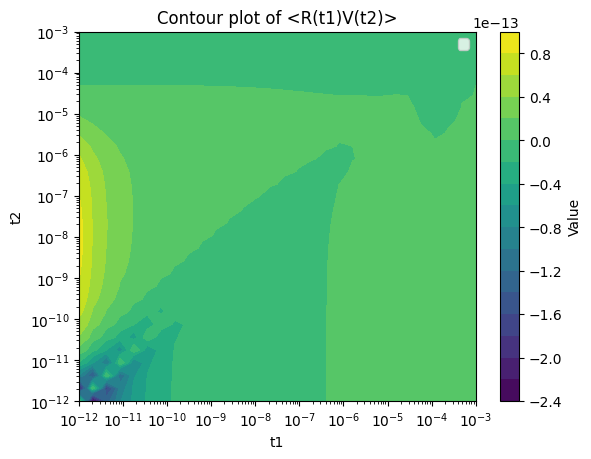

In [13]:

# Now create meshgrid for plotting
XX, YY = np.meshgrid(t1s, t2s)

contour = plt.contourf(XX, YY, values, levels=20)
plt.xscale('log')
plt.yscale('log')  # Optional
plt.xlabel("t1")
plt.ylabel("t2")
plt.legend()
plt.title("Contour plot of <R(t1)V(t2)>")
plt.colorbar(label="Value")
plt.show()